In [9]:
import os 
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
import pickle 
import scipy
import plotly.graph_objects as go
import plotly.io as pio
# Force browser rendering
pio.renderers.default = "browser"
from scipy.ndimage import binary_fill_holes
from pathlib import Path
from skimage import measure
#from utils import *

In [10]:
#UTILS (it can be put on separate file in future)
import nibabel as nib
import numpy as np
import math 
from  tkinter.filedialog import askdirectory
import os
from scipy.ndimage import label
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.spatial import KDTree


#VISUALIZE .NII IMAGES
def visualize_nii(img):
    """
    Plots the sagittal, coronal, and axial views of a NIfTI image.

    Parameters:
    - image_path: str, path to the NIfTI (.nii or .nii.gz) file

     USE THIS COMMAND BEFORE RUNNING IF YOU HAVE IMG PATH : img = nib.load(image_path)
    """
    # Load the NIfTI image
    data = img.get_fdata()

    # Define slice indices for each view (sagittal, coronal, and axial)
    sagittal_slice = data.shape[0] // 2   # Middle slice along the x-axis
    coronal_slice = data.shape[1] // 2    # Middle slice along the y-axis
    axial_slice = data.shape[2] // 2      # Middle slice along the z-axis

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display the sagittal view (x-axis)
    axes[0].imshow(data[sagittal_slice, :, :], cmap="gray", origin="lower")
    axes[0].set_title('Sagittal View')
    axes[0].axis('off')

    # Display the coronal view (y-axis)
    axes[1].imshow(data[:, coronal_slice, :], cmap="gray", origin="lower")
    axes[1].set_title('Coronal View')
    axes[1].axis('off')

    # Display the axial view (z-axis)
    axes[2].imshow(data[:, :, axial_slice], cmap="gray", origin="lower")
    axes[2].set_title('Axial View')
    axes[2].axis('off')

    # Show the figure
    plt.show()

#save image
def save_img(file_to_save,name_to_save, output_dir):
    # Ensure the directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Save the NIfTI image
    nib.save(file_to_save, os.path.join(output_dir, name_to_save))

# Threshold pCT from 300 to 2000: parameters as in Yakuub et al., 2023 Nature
#input = Path containing the Pseudo-CT to threshold
def pCT_threshold(input_pCT,hu_min,hu_max):
    # Check if the file exists
    if not os.path.isfile(input_pCT):
        print(f"File not found: {input_pCT}")
        return None
    
    #hu_min = 300
    #hu_max = 2000

    img = nib.load(input_pCT)

    data = img.get_fdata()

    ct_max = np.max(data)
    if ct_max < hu_max:
        hu_max = ct_max

    skull_model = data

    skull_model = np.where(skull_model < hu_min, 0, skull_model)
    skull_model = np.where(skull_model > hu_max, hu_max, skull_model)

    # Now we can save the changed data into a new NIfTI file
    pCT_thresholded = nib.Nifti1Image(skull_model, affine=img.affine, header=img.header)
    
    return pCT_thresholded

def plot_3D_figure(*args, directory):
    """
    Plot a 3D figure of all the args unpacked and save it in the directory path. 

    Args: 
        args (list): list of all the go objects that are going to be plotted.
        directory (path): place to store the figure.

    Return:
        None, saves the image in the directory argument.
    """
    fig = go.Figure(data=list(args))

    # Update layout for better visualization
    fig.update_layout(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        ),
        scene_aspectmode='data'
    )

    #fig.show()
    fig.write_html(directory)

    # Display the plot in the Jupyter Notebook (does not work on my computer bc not enough powerful)
    fig.show()

def mri_to_voxel(file, target_coordinates):
    """
    Convert MRI coordinates to voxel coordinates using the inverse affine transformation matrix.

    Args:
        file (nib.Nifti1Image): The NIfTI image file containing the affine transformation matrix.
        target_coordinates (np.ndarray): The target coordinates in MRI space (RAS).

    Returns:
        np.ndarray: The corresponding voxel coordinates, rounded to the nearest integers.
    """
    #Get the affine transformation
    affine=file.affine
    inverse_affine = np.linalg.inv(affine)

    #get voxel coordinates 
    voxel_coords = inverse_affine @ target_coordinates
    voxel_coords=np.round(voxel_coords).astype(int)

    return voxel_coords[:3]

def get_biggest_component(binary_data):
    """
    Extracts the largest connected component from a binary image. We only want to plot the scalp's surface 
    and not potential artifacts extracted from the binary image. 

    Args:
        binary_data (numpy.ndarray): A binary image where connected components
                                     are to be identified.

    Returns:
        numpy.ndarray: A binary image containing only the largest connected component.
    """
    # Label connected components in the binary image
    labeled_array, _ = label(binary_data)

    regions = measure.regionprops(labeled_array)

    # Find the region with the maximum area (biggest component)
    max_region = max(regions, key=lambda region: region.area)

    # Create a new binary image with only the largest component
    largest_component_binary = np.zeros_like(binary_data)
    largest_component_binary[tuple(max_region.coords.T)] = 1

    return largest_component_binary

def physical_size_to_voxels(physical_size_mm, voxel_sizes_mm):
    """
    Convert physical size in millimeters to voxel size, assuming isotropic voxel sizes.

    Args:
        physical_size_mm (float): The physical size in millimeters to be converted.
        voxel_sizes_mm (np.ndarray): The voxel sizes in millimeters for each dimension. Assumes isotropic voxels.

    Returns:
        int: The corresponding voxel size.
    """
    voxel_size_mm = voxel_sizes_mm[0]  # Assuming all same size in every direction
    voxel_size = int(physical_size_mm / voxel_size_mm)
    return voxel_size

def tangent_to_surface(verts, intersect_point, radius=30):
    '''
    Determine the tangent to the local surface 

    Inputs:
        verts: represent the surface
        intersect_point (numpy.ndarray): the point around which determine the surface and tangent

    Return:
        normal (numpy.ndarray): normal to the tangent plane 
    '''
    # Create a KDTree for fast nearest neighbor search
    kdtree = KDTree(verts)

    # Find all vertices within the specified radius
    indices = kdtree.query_ball_point(intersect_point, r=radius)
    local_verts = verts[indices]

    # Fit a plane to the local vertices using Singular Value Decomposition (SVD)
    # Center the local vertices
    centroid = local_verts.mean(axis=0)
    centered_verts = local_verts - centroid

    # Perform SVD
    U, S, Vt = np.linalg.svd(centered_verts)
    normal = Vt[2, :]  # The normal to the plane is the last row of Vt

    return normal

def point_translation(intersect_point, voxel_coord, normal, length, file):
    """
    we move the intersect point along the normal of a distance equal of lenght over the scalp mask (so like if we had the transducer over the gelpad)
    Move the transducer placement along the direction of the beam to get the right coordinates for neural navigation and simulation.

    Args:
        intersect_point (numpy.ndarray): The initial intersection point coordinates.
        voxel_coord (numpy.ndarray): The target voxel coordinates.
        normal (numpy.ndarray): The normal vector at the intersection point.
        length (float): The distance to move the intersection point.
        file (nib.Nifti1Image): The NIfTI file object containing the voxel dimensions information.

    Returns:
        numpy.ndarray: The new intersection point after translation.
    """
    
    length=physical_size_to_voxels(length, file.header.get_zooms())
    
    # Calculate the initial distance between point on the scalp and target point before moving
    dist_bf_mv = np.linalg.norm(intersect_point - voxel_coord)
    
    # Translate the intersect point along the normal direction by 'length'
    new_intersect = intersect_point - normal * length

    # Calculate the distance after moving
    dist_after_mv = np.linalg.norm(new_intersect - voxel_coord)

    # If the distance decreased, move in the opposite direction bc that means we're inside the skull
    if dist_after_mv < dist_bf_mv:
        new_intersect = intersect_point + normal * length

    return new_intersect

def determine_thickness_and_porosity(binary_image, non_binary_image, voxel_coord, end_point, direction):
    """Traverse a line from voxel_coord to end_point in the binary image and calculate the thickness.

    Parameters:
        binary_image (numpy.ndarray): 3D numpy array representing the binary image (1 for skull, 0 for background) (we use binary pct thresholded and made binary)
        non_binary_image (numpy.ndarray): 3D numpy array with non-binary values within the skull region. (we use binary pct thresholded)
        voxel_coord (numpy.ndarray): Starting voxel coordinate 
        end_point (numpy.ndarray): End point voxel coordinate
        direction (numpy.ndarray): Direction vector from voxel_coord to end_point.

    Returns:
        thickness (float): The thickness of the skull along the line
        porosity (float): The average value of the non-binary image within the skull region.
        porosity_map (numpy.ndarray): The porosity map .
    """
    # Convert coordinates to numpy arrays for easy calculations
    voxel_coord = np.array(voxel_coord, dtype=np.float64)
    end_point = np.array(end_point, dtype=np.float64)

    #porosity map calculation
    rho_min = 1000 #lower bound for density of the skull 
    rho_max = 1900 #upper bound for density of the skull 
    hu_max = 2000 #intensity max of pct thresholded (300-2000)
    density_range = rho_max - rho_min #range of density values
    density_map =rho_min+ density_range*(non_binary_image -0)/(hu_max-0) 
    #density map obtained by normalizing the voxel values by the maximum possible value of intensity of the skull 
    #then multiplying by the range of density values and adding the minimum density value of the skull
    #eg if we have max intensity we will have 1*900 + 1000 = 1900 which is the upper bound of density for the skull bc max density 
    #derived from CT HU based on Marsac et al., 2017 & Bancel et al., 2021 

    porosity_map = 1-density_map/rho_max #max density is 1900, so porosity is 0 when density is 1900 and 1 when density is 1000

    length = np.linalg.norm(direction)
    direction = direction / length  # Normalize the direction vector

    # Initialize variables to track the first and last skull points
    first_skull_point = None
    last_skull_point = None
    current_point = voxel_coord.copy()
    #skull_values = []  # List to hold non-binary values within the skull region
    porosity_values = []  # List to hold porosity values within the skull region
   
    # Traverse the line
    while True:
        # Round the current point to the nearest voxel index
        voxel_index = np.round(current_point).astype(int)

        # Check if the voxel index is within the image boundaries
        if (0 <= voxel_index[0] < binary_image.shape[0] and
            0 <= voxel_index[1] < binary_image.shape[1] and
            0 <= voxel_index[2] < binary_image.shape[2]):
            
            # Check if the voxel is part of the skull
            if binary_image[voxel_index[0], voxel_index[1], voxel_index[2]] == 1: #if yes we are in skull region
                if first_skull_point is None:
                    first_skull_point = current_point.copy()  # Set the first skull point
                last_skull_point = current_point.copy()  # Update the last skull point
                #skull_values.append(non_binary_image[voxel_index[0], voxel_index[1], voxel_index[2]])  # Append value
                porosity_values.append(porosity_map[voxel_index[0], voxel_index[1], voxel_index[2]])  # Append value
                
        else:
            # Exit if the voxel index is out of bounds
            break

        # Move to the next voxel along the line
        current_point += direction

        # Break if we have reached the end point
        if np.linalg.norm(current_point - voxel_coord) >= length:
            break

    if first_skull_point is not None and last_skull_point is not None:
        # Calculate the thickness as the Euclidean distance between the first and last skull points
        thickness = np.linalg.norm(last_skull_point - first_skull_point)
         # Calculate the porosity as the average of non-binary values within the skull region
        #porosity = np.mean(skull_values) if skull_values else 0
        porosity = np.mean(porosity_values) if porosity_values else 0
    else:
        # If no skull points are found, thickness is zero
        thickness = 0
        porosity = 0 

    return thickness, porosity, porosity_map

def skull_thickness_porosity(skull_binary_image,skull_non_binary_image, verts, target_voxel_coord, search_area_points,n_points, radius=5):
    """
    Calculate the line between the target point and random points, then calculate skull thickness
    based on intersection points and save the results in a DataFrame.

    Parameters:
        n_points (int): Number of random points to generate to calculate thickness and porosity.
        skull_binary_image (numpy.ndarray): pCT thresholded made binary (1 for skull, 0 for background).
        skull_non_binary_image (numpy.ndarray): pct thresholded not binary. 
        verts (numpy.ndarray): Array of vertices from the surface mesh made from the scalp mask.
        target_voxel_coord (numpy.ndarray): Voxel coordinates of the target point.
        random_points (numpy.ndarray): Array of random points on the surface mesh taken as reference.
        radius (float): Radius for tangent plane calculation.

    Returns:
        pd.DataFrame: DataFrame containing the random points and their corresponding skull thickness.
        porosity_map (numpy.ndarray): The porosity map of the skull region.
    """
    #initialization of an array where to store results 
    results = []

    #we take a set of n_points random points on the scalp mesh (used after to compute thickness and porosity)
    #find 10 random point coordinates within the search_area_points
    np.random.seed(0)
    random_indices = np.random.choice(search_area_points.shape[0], n_points, replace=False)
    random_points = search_area_points[random_indices]
   
    # Create a set to track selected points to ensure uniqueness
    selected_points_set = set()
    # Add these initial points to the selected_points_set
    for pt in random_points:
        selected_points_set.add(tuple(pt))

    points_removed = 0  # Counter for points removed due to zero porosity

    for surface_point in tqdm(random_points, desc="Processing random points"):
        while True:
            # Find the line between target point and random point
            direction = surface_point - target_voxel_coord
            normal = tangent_to_surface(verts, surface_point, radius)
            
            # Calculate the distance and intersection point with the skull
            distance = np.linalg.norm(surface_point - target_voxel_coord) #distance between the transducer and the target point
            
            # Calculate the skull thickness at this point
            #thickness = determine_thickness(skull_binary_image, target_voxel_coord, surface_point,  direction)
            thickness, porosity, porosity_map = determine_thickness_and_porosity(skull_binary_image,skull_non_binary_image, target_voxel_coord, surface_point,  direction)
            
            # Check if porosity is zero
            if porosity == 0:
                points_removed += 1

                # Check if all points have been used
                if len(selected_points_set) == len(search_area_points):
                    print(
                        "No more unique points available in search_area_points. "
                        f"Skipping this surface point: {surface_point}"
                    )
                    break  # Exit the loop for this surface point
                
                # Pick a new random point not in selected_points_set
                while True:
                    new_random_index = np.random.randint(search_area_points.shape[0])
                    new_surface_point = search_area_points[new_random_index]
                    if tuple(new_surface_point) not in selected_points_set:
                        break

                # Add the new point to the set and update the current surface_point
                selected_points_set.add(tuple(new_surface_point))
                surface_point = new_surface_point

            else:
                # Save the results and break the loop
                results.append({
                    'target_point_coord': target_voxel_coord,
                    'random_point_coord': surface_point,
                    'thickness': thickness,
                    'porosity': porosity,
                    'points_removed': points_removed
                })
                break

    # Convert results to a DataFrame
    df_results = pd.DataFrame(results)

    return df_results, porosity_map

In [ ]:
'''This code takes as INPUT:
- pCT of petra (coregistered on T1) and T1 obtained from Yaakub (https://www.brainstimjrnl.com/article/S1935-861X(23)00840-9/fulltext) and it will addressed as TP in this code
- scalp mask obtained from the original MRI. It was obtained with 3D Slicer 5.6.1
The coregistration between Petra and T1 was done with FreeSurfer's mri_robust_register

OUTPUT: for each participant and for each imaging technique (t1 and petra)
-  a dataframe containing skull's thickness and porosity values for a set of n points on the scalp (the same points for the 2 techniques)
- scalp and skull binary masks 
- thresholded pCTs (300_2000)
- porosity map nifti 

'''

# Define the base path 
base_path = Path('/Users/win/Desktop/OptimizerGlasser/Alice') 
#base_path = Path('/data/MOTUS_AC/compute_Skull_Thickness_and_porosity')

#list of participant IDs (01,02,03...16) ! CHANGE THE RANGE BASED ON YOUR DATASET (last participant ID + 1) 
#participants = ['{:02d}'.format(i) for i in range(1, 15)]
#participants = ['{:02d}'.format(i) for i in [1]]
participants = sorted([f[3:] for f in os.listdir(base_path / f'INPUT') if f.startswith('MOT')], key=int)


# Loop through each participant ID
for participant in participants:
    print(f"Processing participant {participant}")

    # Define all paths relative to the base path
    scalp_mask_path = base_path / f'INPUT/MOT{participant}/scalp/MOT{participant}_Segmented.nii'
    petra_pct_path = base_path / f'INPUT/MOT{participant}/pCT_petra/petra_registered_on_t1_MOT{participant}_pCT.nii'
    t1_pct_path = base_path / f'INPUT/MOT{participant}/pCT_T1/MOT{participant}_pCT.nii'
    
    #define the threshold for the pCTs
    hu_min = 300
    hu_max = 2000
        
    # Check each path and print an error message if it does not exist 
    # threshold from 300_2000 pCT if they exist
    if not scalp_mask_path.exists():
        print(f"scalp mask not found for participant {participant}")
        continue

    if not petra_pct_path.exists():
        print(f"petra_pct not found for participant {participant}")
        continue
    else:
        petra_pct_300_2000 = pCT_threshold(petra_pct_path,hu_min,hu_max) 
        #save the thresholded pCT
        save_img(petra_pct_300_2000, f'MOT{participant}_petra_thresholded.nii', base_path / f'OUTPUT/MOT{participant}/thresholded_pCTs/MOT{participant}_petra_pct_300_2000')

    if not t1_pct_path.exists():
        print(f"t1_pct not found for participant {participant}")
        continue
    else:
        t1_pct_300_2000 = pCT_threshold(t1_pct_path,hu_min,hu_max)
        #save the thresholded pCT
        save_img(t1_pct_300_2000, f'MOT{participant}_t1_thresholded.nii', base_path / f'OUTPUT/MOT{participant}/thresholded_pCTs/MOT{participant}_t1_pct_300_2000')


    #load data 
    #scalp mask and we make it binary 
    file = nib.load(scalp_mask_path)
    data = file.get_fdata()
    binary_data_scalp = (data > 0).astype(int)
    binary_data_scalp = binary_fill_holes(binary_data_scalp)
    #save binary_data_scalp as nifti file
    save_img(nib.Nifti1Image(binary_data_scalp, affine=file.affine, header=file.header), f'MOT{participant}_binary_scalp_mask.nii', base_path / f'OUTPUT/MOT{participant}/binary_masks')
    
    #pCT thresholded (one for each technique) and we make it binary 
    #Petra
    data_skull=petra_pct_300_2000.get_fdata()
    binary_data_skull= (data_skull !=0).astype(int)
    binary_data_skull=binary_fill_holes(binary_data_skull)
    # Get the biggest component which is the skull using connected components (get rid of artifacts)
    binary_data_skull_petra=get_biggest_component(binary_data_skull)
    #save binary_data_skull_petra as nifti file
    save_img(nib.Nifti1Image(binary_data_skull_petra, affine=petra_pct_300_2000.affine, header=petra_pct_300_2000.header), f'MOT{participant}_binary_skull_petra_thresholded.nii', base_path / f'OUTPUT/MOT{participant}/binary_masks')
    
    #TP T1
    data_skull=t1_pct_300_2000.get_fdata()
    binary_data_skull= (data_skull !=0).astype(int)
    binary_data_skull=binary_fill_holes(binary_data_skull)
    # Get the biggest component which is the skull using connected components (get rid of artifacts)
    binary_data_skull_t1=get_biggest_component(binary_data_skull)
    #save binary_data_skull_t1 as nifti file
    save_img(nib.Nifti1Image(binary_data_skull_t1, affine=t1_pct_300_2000.affine, header=t1_pct_300_2000.header), f'MOT{participant}_binary_skull_t1_thresholded.nii', base_path / f'OUTPUT/MOT{participant}/binary_masks')

    #load pCT images (not thresholded, one for each technique) and make them binary
    #TP T1
    t1_pct = nib.load(t1_pct_path)
    data= t1_pct.get_fdata()
    binary_data = (data > -700).astype(int)
    binary_data = binary_fill_holes(binary_data)
    # Get the biggest component which is the skull using connected components (get rid of artifacts)
    binary_data_t1_pct=get_biggest_component(binary_data)
    #save binary_data_t1_pct as nifti file
    save_img(nib.Nifti1Image(binary_data_t1_pct, affine=t1_pct.affine, header=t1_pct.header), f'MOT{participant}_binary_scalp_t1_pct.nii', base_path / f'OUTPUT/MOT{participant}/binary_masks')


    #TP Petra
    petra_pct = nib.load(petra_pct_path)
    data= petra_pct.get_fdata()
    binary_data = (data > -700).astype(int)
    binary_data = binary_fill_holes(binary_data)
    # Get the biggest component which is the skull using connected components (get rid of artifacts)
    binary_data_petra_pct=get_biggest_component(binary_data)
    #save binary_data_petra_pct as nifti file
    save_img(nib.Nifti1Image(binary_data_petra_pct, affine=petra_pct.affine, header=petra_pct.header), f'MOT{participant}_binary_scalp_petra_pct.nii', base_path / f'OUTPUT/MOT{participant}/binary_masks')


    # EXTRACT SURFACE MESH using the Marching Cubes algorithm on the binary scalp mask (obtained from the MRI)
    '''level: specifies the threshold value at which to find the surface. 
    Isovalue in the 3D volume data where the surface mesh will be extracted.
    level=0.5 to find the boundary between 0 (background) and 1 (foreground)'''

    verts, faces, _, _ = measure.marching_cubes(binary_data_scalp, level=0.5) #returns a set of vertices and triangular faces

    # FIND SURFACE POINTS = skin surface points
    surface_points = np.round(verts).astype(int)

    #TARGET COORDINATES. The target is the point inside the skull we take as a reference to comput thickness and porosity, we take 0,0,0 
    target_coordinates_str = "(-0.00, 0.00, -0.00)"
    target_coord = np.array([float(x.strip()) for x in target_coordinates_str.strip('()').split(',')] + [1])
    target_voxel_coord = mri_to_voxel(file, target_coord) #convert to voxel coordinates within the scalp mask volume on which we did the mesh 

    # The MRI is of shape (208,256,256) 
    # Remove wrong/useless surface points like the neck and face
    surface_points= surface_points[surface_points[:, 2] > 110]#approx. 110, for test 200
    surface_points= surface_points[surface_points[:, 1] < 160]#approx. 160, for test 25
    #define the search area by removing points with the third coordinate < 128
    #if participant is 08 remove points with the second coordinate < 128
    if participant == '08':
         search_area_points= surface_points[surface_points[:, 1] > 128]
    else:
         search_area_points= surface_points[surface_points[:, 2] > 128]
    
    
    # Define the search area (hemisphere) split into left an right hemisphere along the sagittal plane
    '''if target_voxel_coord[0] < 104:
        search_area_points= surface_points[surface_points[:, 0] < 104]
    else:
        search_area_points= surface_points[surface_points[:, 0] >= 104]'''

    '''#VISUALIZATION

    #whole whole scalp area surface 
    surface_all_scatter= go.Scatter3d(
        x=[point[0] for point in surface_points],
        y=[point[1] for point in surface_points],
        z=[point[2] for point in surface_points],
        mode='markers',
        marker=dict(size=2, color='salmon', symbol='circle', opacity=0.7),
        name= 'Search area'
    )
    #plot_3D_figure(surface_all_scatter, directory=base_path / f"OUTPUT/MOT{participant}/whole_search_area.html")
    
    #create the surface mesh in 3d
    scatters=[]
    mesh3d = go.Mesh3d(
        x=verts[:, 0],
        y=verts[:, 1],
        z=verts[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        opacity=0.5,
        color='gray',
    )
    scatters.append(mesh3d)

    #plot_3D_figure(mesh3d, directory=base_path / f"OUTPUT/MOT{participant}/mesh.html") 

    #Plot showing the point we want to target
    point_scatter = go.Scatter3d(
        x=[target_voxel_coord[0]],
        y=[target_voxel_coord[1]],
        z=[target_voxel_coord[2]],
        mode='markers',
        marker=dict(size=5, color='black'),
        name='Target center of mass'
    )
    scatters.append(point_scatter)

    #plot_3D_figure(point_scatter, directory=base_path / f"OUTPUT/MOT{participant}/target.html")

    #plot the search area surface 
    surface_scatter= go.Scatter3d(
        x=[point[0] for point in search_area_points],
        y=[point[1] for point in search_area_points],
        z=[point[2] for point in search_area_points],
        mode='markers',
        marker=dict(size=2, color='salmon', symbol='circle', opacity=0.7),
        name= 'Search area'
    )
    scatters.append(surface_scatter)

    plot_3D_figure(surface_scatter, directory=base_path / f"OUTPUT/MOT{participant}/half_scalp.html")

    # VISUALIZE THE mesh in the search area, the scalp and the target point all together
    '''
    
    n_points = (len( search_area_points)/2)
    #now we compute thickness and porosity for the set of random points for each pCT
    t1_df_results, porosity_map_t1 = skull_thickness_porosity(binary_data_skull_t1, t1_pct_300_2000.get_fdata(),verts,target_voxel_coord,search_area_points,n_points,radius=5)
    petra_df_results, porosity_map_petra= skull_thickness_porosity(binary_data_skull_petra, petra_pct_300_2000.get_fdata(),verts,target_voxel_coord,search_area_points,n_points,radius=5)

    #create a nifti from porosity maps
    affine = t1_pct_300_2000.affine
    porosity_t1_nii = nib.Nifti1Image(porosity_map_t1, affine)

    affine = petra_pct_300_2000.affine
    porosity_petra_nii = nib.Nifti1Image(porosity_map_petra, affine)

    output_dir_nifti = base_path / f"OUTPUT/MOT{participant}/porosity_nii"
    os.makedirs(output_dir_nifti, exist_ok=True)

    nib.save(porosity_t1_nii, output_dir_nifti / f"MOT{participant}_t1_porosity_map.nii")
    nib.save(porosity_petra_nii, output_dir_nifti  / f"MOT{participant}_petra_porosity_map.nii")

    #save the results in a dataframe

    # Create the directory for the CSV file if it does not exist
    output_dir_csv = base_path / f"OUTPUT/MOT{participant}/dataframes"
    os.makedirs(output_dir_csv, exist_ok=True)

    t1_df_results.insert(0, 'Participant', f'MOT{participant}')
    t1_df_results.insert(1, 'Technique', 'Yaakub')
    t1_df_results.insert(2, 'Original MRI', 'T1')
    t1_df_results.to_csv(output_dir_csv /  f"MOT{participant}_yaakub_t1_results.csv", index=False)

    petra_df_results.insert(0, 'Participant', f'MOT{participant}')
    petra_df_results.insert(1, 'Technique', 'Yaakub')
    petra_df_results.insert(2, 'Original MRI', 'Petra')
    petra_df_results.to_csv(output_dir_csv /  f"MOT{participant}_yaakub_petra_results.csv", index=False)

    #show df_results.
    t1_df_results
    petra_df_results

In [ ]:
#DATAFRAMES and POROSITY NIFTI CREATION

# Define the base path and participants (only if not run after the previous cell) 
base_path = Path('/Users/win/Desktop/OptimizerGlasser/Alice') 
#base_path = Path('/data/MOTUS_AC/compute_Skull_Thickness_and_porosity')
participants = sorted([f[3:] for f in os.listdir(base_path / f'INPUT') if f.startswith('MOT')], key=int)


# Loop through each participant ID
for participant in participants:
    print(f"Processing participant {participant}")
    
    #define the path we are working on 
    output_dir_nifti = base_path / f"OUTPUT/MOT{participant}/porosity_nii"
    output_dir_csv = base_path / f"OUTPUT/MOT{participant}/dataframes"

#Compute porosity difference nifti between petra and t1 (part above this can be removed if we copy paste this code inside the main for loop)
    # Define all paths relative to working path
    petra_porosity_path = output_dir_nifti / f'MOT{participant}_petra_porosity_map.nii'
    t1_porosity_map = output_dir_nifti / f'MOT{participant}_t1_porosity_map.nii'
    
    # Check each path and print an error message if it does not exist 
    # threshold from 300_2000 pCT if they exist
    if not petra_porosity_path.exists():
        print(f"Petra porosity nifti not found for participant {participant}")
        continue

    if not t1_porosity_map.exists():
        print(f"T1 porosity nifti not found for participant {participant}")
        continue

    # Load the NIfTI files
    petra_porosity_img = nib.load(petra_porosity_path)
    t1_porosity_img = nib.load(t1_porosity_map)

    # Get the image data as numpy arrays
    petra_porosity_data = petra_porosity_img.get_fdata()
    t1_porosity_data = t1_porosity_img.get_fdata()

    # Compute the difference image
    difference_data = t1_porosity_data - petra_porosity_data

    # Set a difference range for visualization
    min_diff = -1  # Minimum value to display
    max_diff = 1   # Maximum value to display

    # Save the difference image as a new NIfTI file
    difference_img = nib.Nifti1Image(difference_data, affine=t1_porosity_img.affine)
    nib.save(difference_img, output_dir_nifti / f'MOT{participant}_porosity_difference.nii')

    # Visualize the difference image 
    plt.figure(figsize=(15, 5))

    # T1
    plt.subplot(1, 3, 1)
    plt.imshow(t1_porosity_data[:, :, t1_porosity_data.shape[2] // 2], cmap='gray')
    plt.title('T1 porosity map')
    plt.colorbar(label='Voxel Intensity')

    # Petra
    plt.subplot(1, 3, 2)
    plt.imshow(petra_porosity_data[:, :, petra_porosity_data.shape[2] // 2], cmap='gray')
    plt.title('Petra porosity map')
    plt.colorbar(label='Voxel Intensity')

    # Difference Image
    plt.subplot(1, 3, 3)
    plt.imshow(difference_data[:, :, difference_data.shape[2] // 2], cmap='seismic', vmin=min_diff, vmax=max_diff)
    plt.title('T1 - Petra')
    plt.colorbar(label='Voxel Intensity Difference')

    # Save the entire figure as an image
    plt.tight_layout()
    plt.savefig(output_dir_nifti / f'MOT{participant}_porosity_diff_schematic.png', dpi=300)
    print(f"Porosity difference nii correctly saved for participant {participant}")

    plt.close()  # Close the figure to free memory
    #plt.show()


#compute a df with T1 - petra porosity and thickness (one value for each point)
    # Load the two dataframes
    petra_df = pd.read_csv(output_dir_csv / f'MOT{participant}_yaakub_petra_results.csv')
    t1_df = pd.read_csv(output_dir_csv / f'MOT{participant}_yaakub_t1_results.csv')

    # Merge the dataframes based on the common columns
    merged_df = pd.merge(
        t1_df, 
        petra_df, 
        on=['Participant', 'Technique', 'target_point_coord', 'random_point_coord'],
        suffixes=('_T1', '_Petra')
    )

    # Create the new columns
    merged_df['MRI'] = 'T1 - Petra'
    merged_df['delta_thickness'] = merged_df['thickness_T1'] - merged_df['thickness_Petra']
    merged_df['delta_porosity'] = merged_df['porosity_T1'] - merged_df['porosity_Petra']

    # Select the desired columns for the new dataframe
    result_df = merged_df[['Participant', 'Technique', 'MRI', 'target_point_coord', 'random_point_coord', 'delta_thickness', 'delta_porosity']]

    # Save or display the result
    result_df.to_csv(output_dir_csv / f'MOT{participant}_results_diff.csv', index=False)
    print(f"results df correctly saved for participant {participant}")
    #print(result_df)


#Df containing an average of all data divided by participant 

# Define the main directory containing participant folders
output_dir = base_path / f'OUTPUT'
participants = sorted([f[3:] for f in os.listdir(output_dir) if f.startswith('MOT')], key=int)

# Initialize an empty list to store results
summary_data = []

# Iterate through each participant folder
for participant in participants:
    print(f"Processing participant {participant} for result df creation")
    
    # Define the path to the results_diff.csv file
    results_file = output_dir / f"MOT{participant}/dataframes/MOT{participant}_results_diff.csv"
    
    # Load the participant's DataFrame
    df = pd.read_csv(results_file)
    
    # Calculate the statistics
    mean_thickness = df['delta_thickness'].mean()
    max_thickness = df['delta_thickness'].max()
    min_thickness = df['delta_thickness'].min()
    mean_porosity = df['delta_porosity'].mean()
    max_porosity = df['delta_porosity'].max()
    min_porosity = df['delta_porosity'].min()
    
    # Extract common values
    technique = df['Technique'].iloc[0]
    mri = df['MRI'].iloc[0]
    
    # Append the summary for this participant
    summary_data.append({
        'Participant': participant,
        'Technique': technique,
        'MRI': mri,
        'Mean_delta_thickness': mean_thickness,
        'Max_delta_thickness': max_thickness,
        'Min_delta_thickness': min_thickness,
        'Mean_delta_porosity': mean_porosity,
        'Max_delta_porosity': max_porosity,
        'Min_delta_porosity': min_porosity
    })

# Create a summary DataFrame
summary_df = pd.DataFrame(summary_data)

# Save the summary DataFrame to a CSV file
summary_df.to_csv(os.path.join(output_dir, "participants_mean_results.csv"), index=False)


# Calculate the overall averages across all participants
overall_means = {
    'Participant': 'Overall Average',
    'Technique': summary_df['Technique'].iloc[0],  # Assuming the same technique for all participants
    'MRI': summary_df['MRI'].iloc[0],              # Assuming the same MRI value for all participants
    'Mean_delta_thickness': summary_df['Mean_delta_thickness'].mean(),
    'Max_delta_thickness': summary_df['Max_delta_thickness'].mean(),
    'Min_delta_thickness': summary_df['Min_delta_thickness'].mean(),
    'Mean_delta_porosity': summary_df['Mean_delta_porosity'].mean(),
    'Max_delta_porosity': summary_df['Max_delta_porosity'].mean(),
    'Min_delta_porosity': summary_df['Min_delta_porosity'].mean()
}

# Use pd.concat to append the overall averages row
overall_means_df = pd.DataFrame([overall_means])
overall_means_df = pd.concat([summary_df, overall_means_df], ignore_index=True)

# Save the summary DataFrame to a CSV file
overall_means_df.to_csv(os.path.join(output_dir, "overall_results.csv"), index=False)


# Print the summary DataFrame
print(summary_df)
print(overall_means_df)

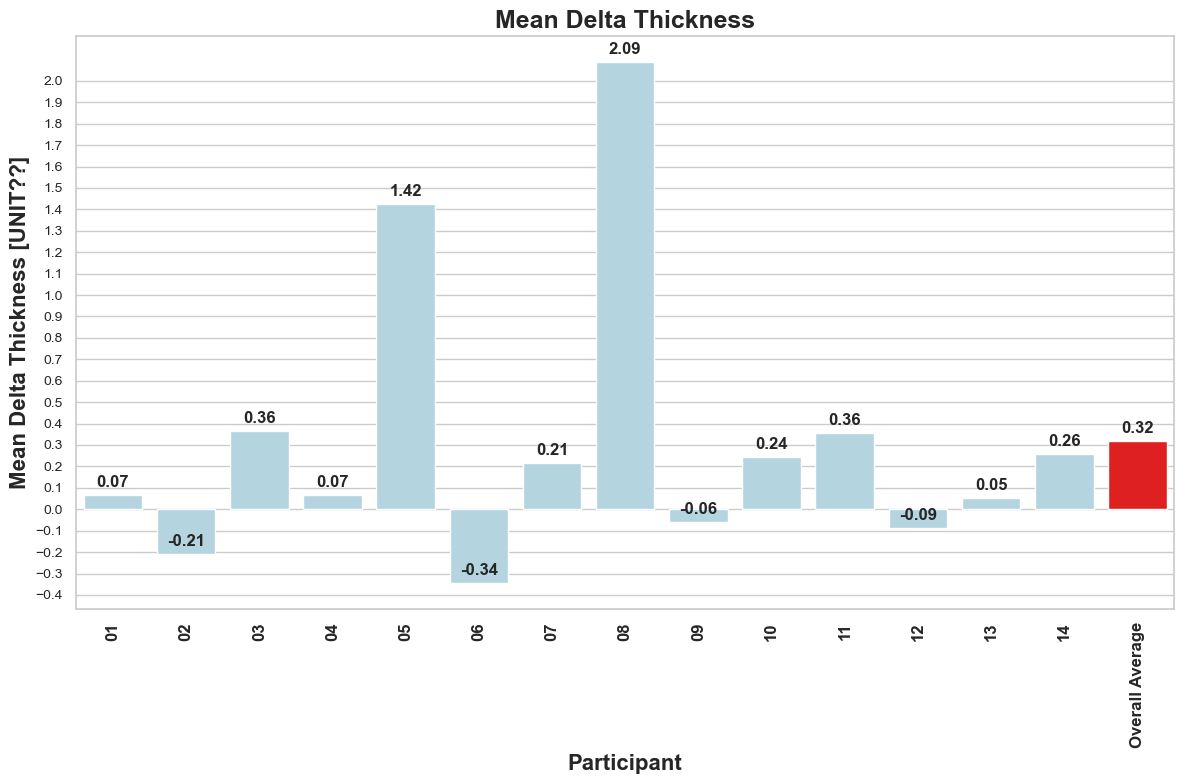

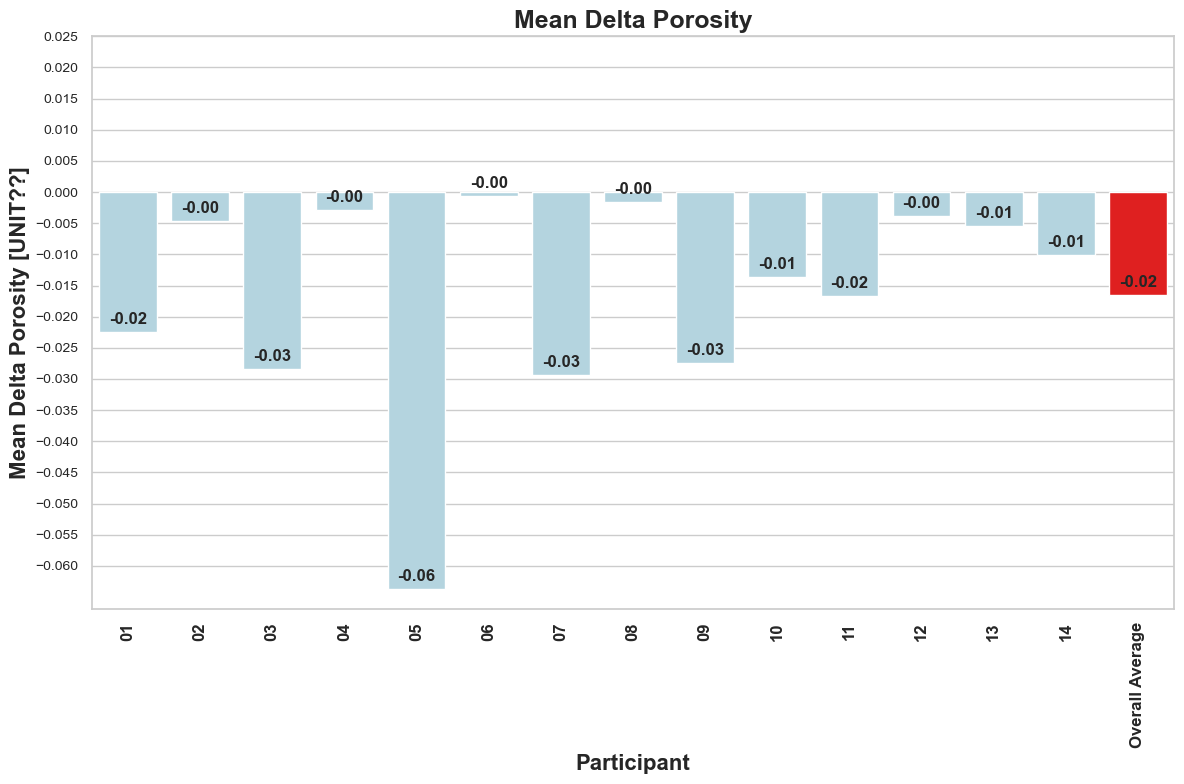

In [ ]:
#GRAPH CREATION (DATA ANALYSIS)

base_path = Path('/Users/win/Desktop/OptimizerGlasser/Alice') 
#base_path = Path('/data/MOTUS_AC/compute_Skull_Thickness_and_porosity')
participants = sorted([f[3:] for f in os.listdir(output_dir) if f.startswith('MOT')], key=int)
participants= ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14']


output_dir = base_path / f'OUTPUT'

# List to hold all DataFrames
dataframes = []

# Iterate through each participant folder and load the data
for participant in participants:
    results_file = output_dir / f'dataframes_temp/MOT{participant}_results_diff.csv'
    df = pd.read_csv(results_file)
    dataframes.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(dataframes, ignore_index=True)

# Create a figure with two subplots (two rows, one column)
fig, axs = plt.subplots(2, 1, figsize=(20, 20))

# Add a title to the figure
# fig.suptitle('Total time on food-objects under different habituation conditions', fontsize=18, weight='bold')

# Plot the scatterplot and boxplot for 'delta_thickness' on the first subplot
sns.scatterplot(data=combined_df, x='delta_thickness', y='Participant', hue='Participant', legend=False, marker='x', linewidth=3, s=100, ax=axs[0])
sns.boxplot(data=combined_df, x='delta_thickness', y='Participant', color='darkgrey', linewidth=4, fliersize=0, boxprops=dict(alpha=0.5, color='darkgrey'), width=0.4, ax=axs[0])
axs[0].axvline(x=0, color='grey', linestyle='--', linewidth=2)  # Add vertical dashed line at x=0
axs[0].set_xlabel('Delta Thickness [UNIT??]', fontsize=16, weight='bold')
axs[0].set_ylabel('Participant', fontsize=18, weight='bold')
axs[0].set_xlim([-18, 18])
axs[0].tick_params(axis='both', labelsize=16, rotation=45)
axs[0].set_yticks(range(len(participants)))

# Plot the scatterplot and boxplot for 'delta_porosity' on the second subplot
sns.scatterplot(data=combined_df, x='delta_porosity', y='Participant', hue='Participant', legend=False, marker='x', linewidth=3, s=100, ax=axs[1])
sns.boxplot(data=combined_df, x='delta_porosity', y='Participant', color='darkgrey', linewidth=4, fliersize=0, boxprops=dict(alpha=0.5, color='darkgrey'), width=0.4, ax=axs[1])
axs[1].axvline(x=0, color='grey', linestyle='--', linewidth=2)  # Add vertical dashed line at x=0
axs[1].set_xlabel('Delta Porosity [UNIT??]', fontsize=16, weight='bold')
axs[1].set_ylabel('Participant', fontsize=18, weight='bold')
axs[1].set_xlim([-0.15, 0.15])
axs[1].tick_params(axis='both', labelsize=16, rotation=45)
axs[1].set_yticks(range(len(participants)))

# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust the top padding to make room for the title
plt.show()


## HISTOGRAMS WITH ONE MEAN FOR EACH PARTICIPANT AND OVERALL MEAN 
overall_df =  output_dir / f"overall_results.csv"
overall_df = pd.read_csv(overall_df)

# Convert numerical columns to float
overall_df["Mean_delta_thickness"] = overall_df["Mean_delta_thickness"].astype(float)

# Define the colors for the bars
colors = ['lightblue'] * (len(overall_df) - 1) + ['red']  # All bars blue except the last one red

# Create a barplot
plt.figure(figsize=(12, 8))
barplot = sns.barplot(data=overall_df, x='Participant', y='Mean_delta_thickness',hue='Participant', palette=colors, legend=False)
plt.title('Mean Delta Thickness', fontsize=18, weight='bold')
plt.xlabel('Participant', fontsize=16, weight='bold')
plt.ylabel('Mean Delta Thickness [UNIT??]', fontsize=16, weight='bold')

# Add the corresponding value of Mean_delta_thickness on top of each column
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points', 
                     fontsize=12, weight='bold')

# Set y-ticks to the unique values of Mean_delta_thickness
y_ticks = np.arange(-0.4, 2.1, 0.1)  # Start, stop, and interval
plt.yticks(y_ticks, fontsize=10)

# Add vertical labels on the x-axis
plt.xticks(rotation=90, fontsize=12, weight='bold')

# Show the plot
plt.tight_layout()
plt.show()

#create another plot for Mean_delta_porosity
# Convert numerical columns to float
overall_df["Mean_delta_porosity"] = overall_df["Mean_delta_porosity"].astype(float)

# Define the colors for the bars
colors = ['lightblue'] * (len(overall_df) - 1) + ['red']  # All bars blue except the last one red

# Create a barplot
plt.figure(figsize=(12, 8))
barplot = sns.barplot(data=overall_df, x='Participant', y='Mean_delta_porosity',hue='Participant', palette=colors, legend=False)
plt.title('Mean Delta Porosity', fontsize=18, weight='bold')
plt.xlabel('Participant', fontsize=16, weight='bold')
plt.ylabel('Mean Delta Porosity [UNIT??]', fontsize=16, weight='bold')

# Add the corresponding value of Mean_delta_thickness on top of each column
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points', 
                     fontsize=12, weight='bold')

# Set y-ticks to the unique values of Mean_delta_thickness
y_ticks = np.arange(-0.06, 0.03, 0.005)  # Start, stop, and interval
plt.yticks(y_ticks, fontsize=10)

# Add vertical labels on the x-axis
plt.xticks(rotation=90, fontsize=12, weight='bold')

# Show the plot
plt.tight_layout()
plt.show()



c:\Users\win\miniconda3\envs\img_analysis_ramdya\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
c:\Users\win\miniconda3\envs\img_analysis_ramdya\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


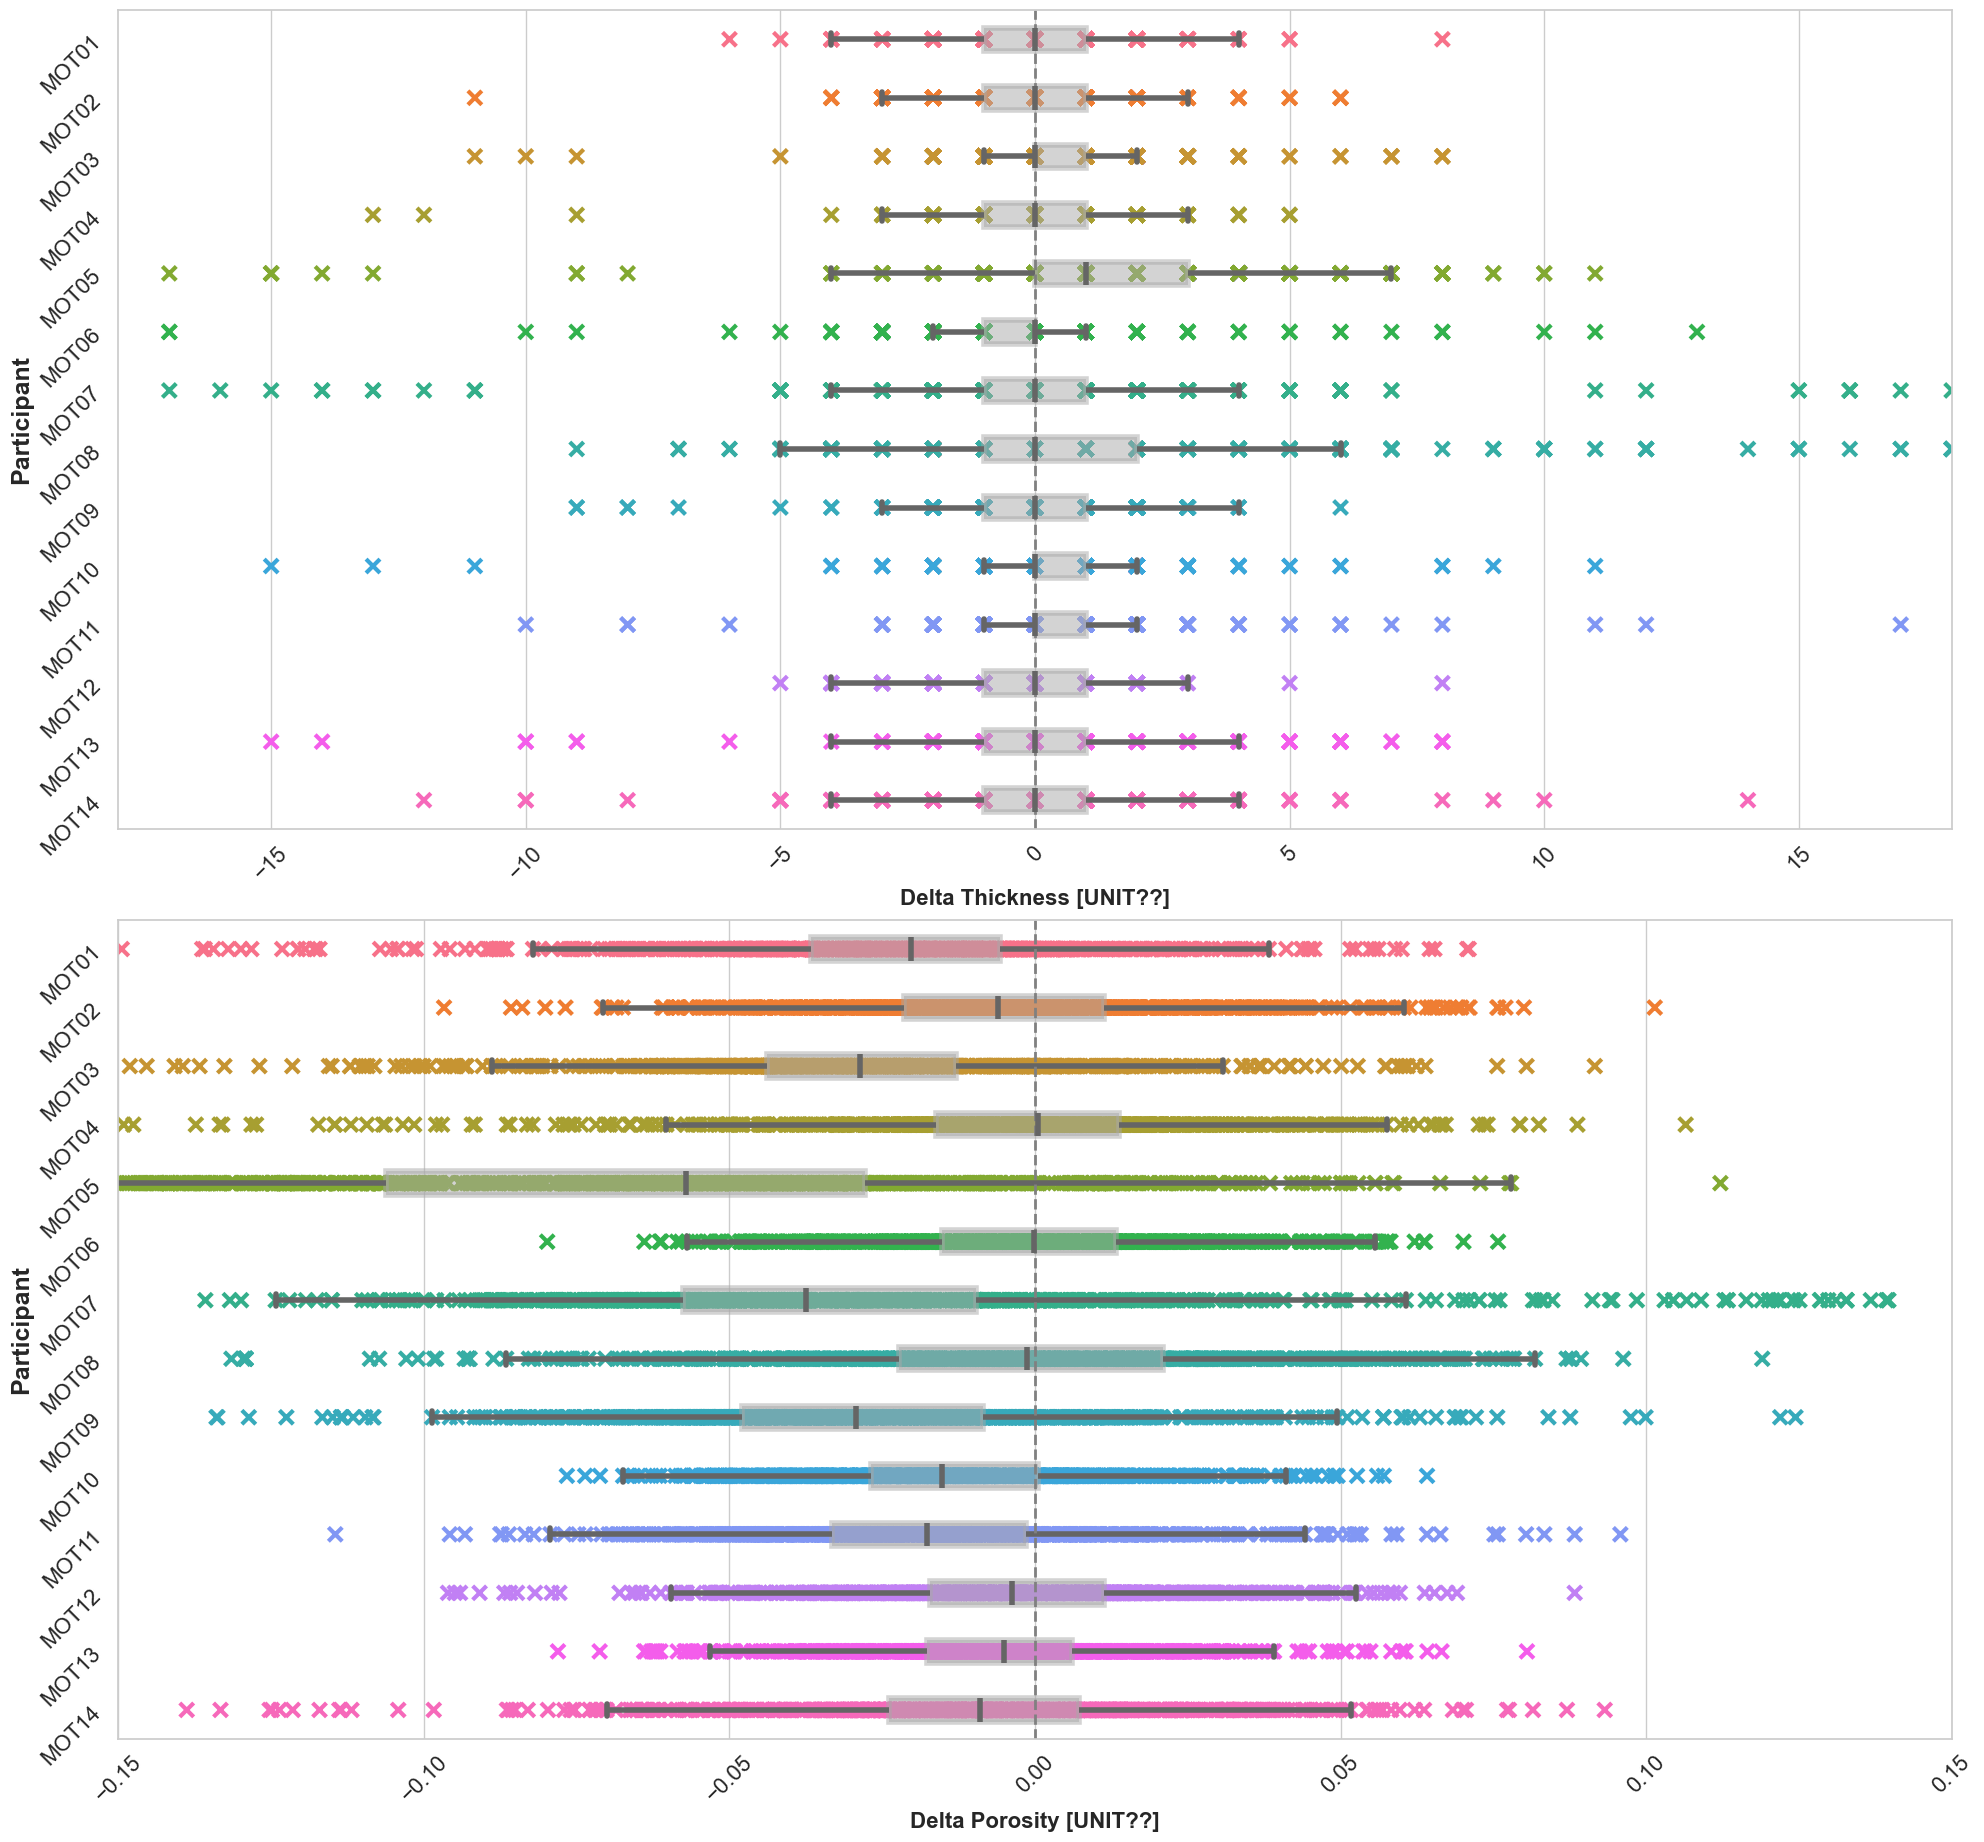

In [46]:

base_path = Path('/Users/win/Desktop/OptimizerGlasser/Alice') 
#base_path = Path('/data/MOTUS_AC/compute_Skull_Thickness_and_porosity')
output_dir = base_path / f'OUTPUT'
participants = sorted([f[3:] for f in os.listdir(output_dir) if f.startswith('MOT')], key=int)

participants= ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14']


# List to hold all DataFrames
dataframes = []

# Iterate through each participant folder and load the data
for participant in participants:
    results_file = output_dir / f'dataframes_temp/MOT{participant}_results_diff.csv'
    df = pd.read_csv(results_file)
    dataframes.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(dataframes, ignore_index=True)

# Create a figure with two subplots (two rows, one column)
fig, axs = plt.subplots(2, 1, figsize=(20, 20))

# Add a title to the figure
# fig.suptitle('Total time on food-objects under different habituation conditions', fontsize=18, weight='bold')

# Plot the scatterplot and boxplot for 'delta_thickness' on the first subplot
sns.scatterplot(data=combined_df, x='delta_thickness', y='Participant', hue='Participant', legend=False, marker='x', linewidth=3, s=100, ax=axs[0])
sns.boxplot(data=combined_df, x='delta_thickness', y='Participant', color='darkgrey', linewidth=4, fliersize=0, boxprops=dict(alpha=0.5, color='darkgrey'), width=0.4, ax=axs[0])
axs[0].axvline(x=0, color='grey', linestyle='--', linewidth=2)  # Add vertical dashed line at x=0
axs[0].set_xlabel('Delta Thickness [UNIT??]', fontsize=16, weight='bold')
axs[0].set_ylabel('Participant', fontsize=18, weight='bold')
axs[0].set_xlim([-18, 18])
axs[0].tick_params(axis='both', labelsize=16, rotation=45)
axs[0].set_yticks(range(len(participants)))

# Plot the scatterplot and boxplot for 'delta_porosity' on the second subplot
sns.scatterplot(data=combined_df, x='delta_porosity', y='Participant', hue='Participant', legend=False, marker='x', linewidth=3, s=100, ax=axs[1])
sns.boxplot(data=combined_df, x='delta_porosity', y='Participant', color='darkgrey', linewidth=4, fliersize=0, boxprops=dict(alpha=0.5, color='darkgrey'), width=0.4, ax=axs[1])
axs[1].axvline(x=0, color='grey', linestyle='--', linewidth=2)  # Add vertical dashed line at x=0
axs[1].set_xlabel('Delta Porosity [UNIT??]', fontsize=16, weight='bold')
axs[1].set_ylabel('Participant', fontsize=18, weight='bold')
axs[1].set_xlim([-0.15, 0.15])
axs[1].tick_params(axis='both', labelsize=16, rotation=45)
axs[1].set_yticks(range(len(participants)))

# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust the top padding to make room for the title
plt.show()

In [ ]:
#count how many surface_points we have in the search area 
len(search_area_points)


def compute_triangle_side_lengths(verts, faces):
    """
    Compute the lengths of the sides of each triangle in the mesh.

    Parameters:
        verts (numpy.ndarray): Array of vertices (Nx3).
        faces (numpy.ndarray): Array of triangular faces (Mx3), where each row contains indices of the vertices.

    Returns:
        numpy.ndarray: Array of side lengths for each triangle (Mx3).
    """
    # Extract the vertices of each triangle
    v0 = verts[faces[:, 0]]
    v1 = verts[faces[:, 1]]
    v2 = verts[faces[:, 2]]
    
    # Compute the lengths of the three sides of each triangle
    side_lengths = np.zeros((faces.shape[0], 3))
    side_lengths[:, 0] = np.linalg.norm(v1 - v0, axis=1)  # Length of edge between v0 and v1
    side_lengths[:, 1] = np.linalg.norm(v2 - v1, axis=1)  # Length of edge between v1 and v2
    side_lengths[:, 2] = np.linalg.norm(v0 - v2, axis=1)  # Length of edge between v2 and v0
    
    return side_lengths

# Example usage
triangle_side_lengths = compute_triangle_side_lengths(verts, faces)
print(f"Triangle side lengths (first triangle): {triangle_side_lengths[0]}")
print(f"Average side length: {np.mean(triangle_side_lengths)}")


Triangle side lengths (first triangle): [0.70710677 0.70710677 0.70710677]
Average side length: 0.9999527378585067
